<a href="https://colab.research.google.com/github/jasonzmiller/msd.recsys/blob/main/bpr04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Aug 20 21:39:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import numpy as np
import pandas as pd
import scipy as sp
from collections import OrderedDict
from tqdm import tqdm
from typing import Dict

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Embedding, Flatten, Input, Lambda
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
reldir = 'drive/MyDrive/msd.recsys/'

In [5]:
df = pd.read_csv(reldir + 'datasets/clean.csv', sep='\t', compression='zip')

In [6]:
# Convert user id and song id to numerical ids
df['user_id'] = df['user'].astype('category').cat.codes
df['song_id'] = df['song'].astype('category').cat.codes

df_orig = df.copy()

# Create lookup frame so we can get the 'Song - Artist' later
item_lookup = df[['song_id','Song - Artist']].drop_duplicates()
item_lookup['song_id'] = item_lookup['song_id'].astype(str)

# Drop 'user' and 'song' and 'Song - Artist'
df = df.drop(['user','song','Song - Artist'], axis=1)

df = df.sort_values(by=['user_id', 'song_id'])

aggd = df.groupby('user_id')['song_id'].agg(list).reset_index()
nuser_listens = {row['user_id'] : row['song_id'] for _ , row in aggd.iterrows()}

# Create lists of all unique users, songs
uusers = list(np.sort(df['user_id'].unique()))
usongs = list(np.sort(df['song_id'].unique()))
nusers = len(uusers)
nsongs = len(usongs)

### Validation hold-out

In [7]:
tmp_val = (
        df.groupby('user_id')['song_id'].count()
    ).reset_index().rename({'song_id':'records'}, axis=1)
tmp_val.shape

(418252, 2)

In [8]:
min_records = 3
conditions = df['user_id'].isin(tmp_val[tmp_val['records'] > min_records].user_id)
df_val = df[conditions].groupby('user_id').head(1).reset_index()
del df_val['index']
df_val.shape

(41355, 3)

In [9]:
ground_truth = { row.user_id : row.song_id for _ , row in df_val.iterrows() }
df_train = pd.concat([df, df_val]).drop_duplicates(keep=False)

### Building Triplets

In [ ]:
# %%time

# data = []
# n_random_samples = 2

# uusers_train = list(df_train['user_id'].unique())

# for user in tqdm( uusers_train ):
#     listened = df_train[df_train['user_id'] == user]['song_id'].values
    
#     for i in listened:
#         cnt = 0
#         while ( cnt < n_random_samples ):
#             j = df_train.sample(1).iloc[0,2]
#             if ( j not in listened ):
#                 data.append({
#                     'u' : user,
#                     'i' : i,
#                     'j' : j
#                 })
#                 cnt += 1

# ttriplets = pd.DataFrame(data, columns=['u', 'i', 'j'])

In [ ]:
# ttriplets.to_csv(reldir + 'datasets/ttriplets.csv', compression='zip', sep='\t')

In [10]:
ttriplets = pd.read_csv(reldir+'datasets/ttriplets.csv', compression='zip', sep='\t')

In [11]:
X = {
    'user_input': tf.convert_to_tensor(ttriplets.u),
    'positive_item_input': tf.convert_to_tensor(ttriplets.i),
    'negative_item_input': tf.convert_to_tensor(ttriplets.j)
}

### Build model

In [12]:
@tf.function
def identity_loss(_, y_pred):
    return tf.math.reduce_mean(y_pred)

@tf.function
def triplet_loss(X: dict):
    i_latent , j_latent , u_latent = X
    pos_interactions = tf.math.reduce_sum(tf.math.multiply(u_latent, i_latent), axis=-1, keepdims=True)
    neg_interactions = tf.math.reduce_sum(tf.math.multiply(u_latent, j_latent), axis=-1, keepdims=True)
    return tf.math.subtract(tf.constant(1.0), tf.sigmoid(tf.math.subtract(pos_interactions, neg_interactions)))

def out_shape(shapes):
    return shapes[0]

In [13]:
def build_model(num_users: int, num_items: int, latent_dim: int) -> Model:
    u_input = Input((1,), name='user_input')
    i_input = Input((1,), name='positive_item_input')
    j_input = Input((1,), name='negative_item_input')
    
    item_emb = Embedding(num_items, latent_dim, name='item_embedding', input_length=1)
    i_emb = Flatten()( item_emb(i_input) )
    j_emb = Flatten()( item_emb(j_input) )
    
    u_emb = Embedding(num_users, latent_dim, name='user_embedding', input_length=1)(u_input)
    u_emb = Flatten()(u_emb)
    
    t_loss = Lambda(triplet_loss, output_shape=out_shape, name='triplet_loss')([i_emb, j_emb, u_emb])
    
    model = Model(inputs=[i_input, j_input, u_input], outputs=t_loss)
    
    return model

#### Functions used to evaluate the models

In [14]:
def get_weights(model: Model, song_ids: list):
    u = model.get_layer('user_embedding').get_weights()[0]
    i = model.get_layer('item_embedding').get_weights()[0][song_ids]
    return u, i

def get_topk(model, user, usongs, weights, k=10):
    user_weights, item_weights = weights
    
    user_vector = user_weights[user]
    item_matrix = item_weights
    
    scores = np.dot(user_vector, item_matrix.T)
    
    predictions = dict(zip(usongs,scores))
    predictions = sorted(predictions.items(), key=lambda kv:kv[1], reverse=True)[:k]
    predictions = list(OrderedDict(predictions).keys())
    
    return predictions

def get_hits(user_listens, user_recs):
    hits = 0
    for song in user_listens:
        if ( song in user_recs ):
            hits += 1
    return hits

def get_metrics(uusers: list, nuser_listens: dict, nuser_recs: dict, N: int, k=10):
    nusers = len(uusers)
    precision = recall = t_hits = 0
    
    for user in tqdm(uusers, desc='Getting metrics... '):
        hits = get_hits(user_listens=nuser_listens[user], user_recs=nuser_recs[user])
        precision += hits / len(nuser_listens[user])
        recall += hits / k
        t_hits += hits
                                
    precision = precision / nusers
    recall = recall / nusers
    hit_ratio = t_hits / N
    
    return precision, recall, hit_ratio

def hold_out_hit_ratio(ground_truth: dict, nuser_recs: dict):
    hits = 0
    for _ , (user , song) in enumerate(ground_truth.items()):
        if song in nuser_recs[user]:
            hits += 1
    return hits / (len(ground_truth) if len(ground_truth) > 0 else 1)

def evaluate(model: Model, uusers: list, usongs: list, nuser_listens: dict, N: int, ground_truth=None, k=10):
    weights = get_weights(model, usongs)
    nuser_recs = {user : get_topk(model=model, user=user, usongs=usongs, weights=weights) for user in tqdm(uusers, desc='Generating recommendations for all users... ')}
    p , r , hr = get_metrics(uusers=uusers, nuser_listens=nuser_listens, nuser_recs=nuser_recs, N=N)
    hoh = hold_out_hit_ratio(ground_truth, nuser_recs)
        
    evals = {
        'precision' : p,
        'recall' : r,
        'hit_ratio' : hr,
        'hold_out_hits': hoh
    }
    return evals

In [15]:
#---------------
#  HYPERPARAMS
#---------------
latent_dims = [200, 250, 300, 350]
batch_size = 2048
epochs = 3
learning_rates = [0.001, 0.01, 0.1]

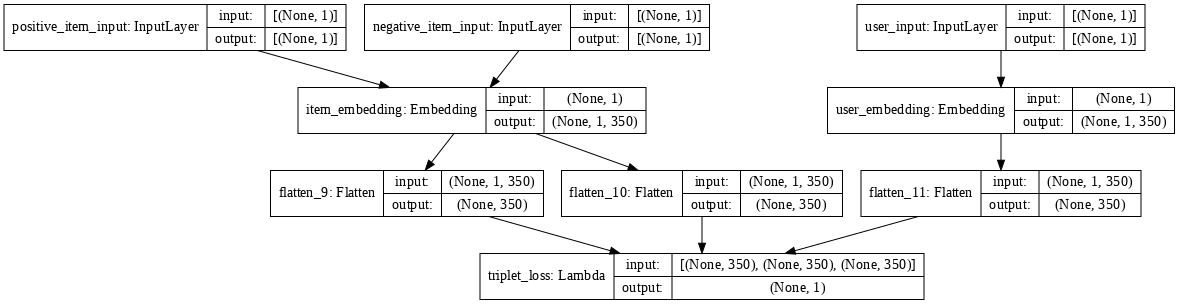

In [ ]:
vis_model = build_model(nusers, nsongs, latent_dims[3])
vis_model.compile(loss=identity_loss, optimizer=Adam(learning_rates[1]))
plot_model(model = vis_model , dpi=72, show_shapes=True)

In [18]:
model_hist = []
for latent_dim in latent_dims:
    for learning_rate in learning_rates:
        print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
        print(f'LATENT_DIMENSIONS: {latent_dim}. LEARNING_RATE: {learning_rate}')
        model = build_model(nusers, nsongs, latent_dim)
        model.compile(loss=identity_loss, optimizer=Adam(learning_rate))
        model.fit(X, tf.ones(ttriplets.shape[0]), batch_size, verbose=1, epochs=epochs)
        evals = evaluate(model=model, uusers=uusers, usongs=usongs, nuser_listens=nuser_listens, ground_truth=ground_truth, N=df.shape[0])
        print(evals)
        model_hist.append({
            'latent_dim' : latent_dim,
            'learning_rate' : learning_rate,
            'precision' : evals['precision'],
            'recall' : evals['recall'],
            'hit_ratio' : evals['hit_ratio'],
            'hold_out_hits' : evals['hold_out_hits']
        })

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
LATENT_DIMENSIONS: 200. LEARNING_RATE: 0.001
Epoch 1/3
715/715 [==============================] - 16s 21ms/step - loss: 0.4830
Epoch 2/3
715/715 [==============================] - 15s 21ms/step - loss: 0.1914
Epoch 3/3
715/715 [==============================] - 15s 21ms/step - loss: 0.0278


Getting metrics... : 100%|██████████| 418252/418252 [00:04<00:00, 84219.99it/s]


{'precision': 0.8980457175065435, 'recall': 0.15744001224072504, 'hit_ratio': 0.8522443866068042, 'hold_out_hits': 0.1895538628944505}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
LATENT_DIMENSIONS: 200. LEARNING_RATE: 0.01
Epoch 1/3
715/715 [==============================] - 16s 21ms/step - loss: 0.2650
Epoch 2/3
715/715 [==============================] - 15s 21ms/step - loss: 0.0021
Epoch 3/3
715/715 [==============================] - 15s 21ms/step - loss: 4.7298e-04


Getting metrics... : 100%|██████████| 418252/418252 [00:04<00:00, 95002.47it/s]


{'precision': 0.9646850853675477, 'recall': 0.1687664374583084, 'hit_ratio': 0.9135558802631426, 'hold_out_hits': 0.14723733526780317}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
LATENT_DIMENSIONS: 200. LEARNING_RATE: 0.1
Epoch 1/3
715/715 [==============================] - 16s 21ms/step - loss: 0.3160
Epoch 2/3
715/715 [==============================] - 15s 21ms/step - loss: 0.1375
Epoch 3/3
715/715 [==============================] - 15s 21ms/step - loss: 0.1234


Getting metrics... : 100%|██████████| 418252/418252 [00:07<00:00, 52877.63it/s]


{'precision': 0.6469317803184378, 'recall': 0.09341951741957141, 'hit_ratio': 0.5056926647003019, 'hold_out_hits': 0.046644903881030104}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
LATENT_DIMENSIONS: 250. LEARNING_RATE: 0.001
Epoch 1/3
715/715 [==============================] - 19s 26ms/step - loss: 0.4792
Epoch 2/3
715/715 [==============================] - 19s 26ms/step - loss: 0.1671
Epoch 3/3
715/715 [==============================] - 19s 26ms/step - loss: 0.0207


Getting metrics... : 100%|██████████| 418252/418252 [00:04<00:00, 86886.16it/s]


{'precision': 0.9166975665502859, 'recall': 0.16112845844070525, 'hit_ratio': 0.872210451931701, 'hold_out_hits': 0.18829645750211582}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
LATENT_DIMENSIONS: 250. LEARNING_RATE: 0.01
Epoch 1/3
715/715 [==============================] - 19s 26ms/step - loss: 0.2592
Epoch 2/3
715/715 [==============================] - 19s 26ms/step - loss: 0.0020
Epoch 3/3
715/715 [==============================] - 19s 26ms/step - loss: 4.2703e-04


Getting metrics... : 100%|██████████| 418252/418252 [00:04<00:00, 94116.74it/s]


{'precision': 0.968305749013853, 'recall': 0.16976392222827957, 'hit_ratio': 0.9189554021750806, 'hold_out_hits': 0.14697134566557854}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
LATENT_DIMENSIONS: 250. LEARNING_RATE: 0.1
Epoch 1/3
715/715 [==============================] - 19s 26ms/step - loss: 0.3166
Epoch 2/3
715/715 [==============================] - 19s 26ms/step - loss: 0.1411
Epoch 3/3
715/715 [==============================] - 19s 26ms/step - loss: 0.1277


Getting metrics... : 100%|██████████| 418252/418252 [00:07<00:00, 54678.43it/s]


{'precision': 0.6574846213080764, 'recall': 0.09473236230732403, 'hit_ratio': 0.5127992741965752, 'hold_out_hits': 0.05012694958287994}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
LATENT_DIMENSIONS: 300. LEARNING_RATE: 0.001
Epoch 1/3
715/715 [==============================] - 23s 31ms/step - loss: 0.4756
Epoch 2/3
715/715 [==============================] - 22s 31ms/step - loss: 0.1474
Epoch 3/3
715/715 [==============================] - 22s 31ms/step - loss: 0.0160


Getting metrics... : 100%|██████████| 418252/418252 [00:04<00:00, 88143.42it/s]


{'precision': 0.9303181282093198, 'recall': 0.1639647867787097, 'hit_ratio': 0.8875638863615479, 'hold_out_hits': 0.20137830975698223}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
LATENT_DIMENSIONS: 300. LEARNING_RATE: 0.01
Epoch 1/3
715/715 [==============================] - 23s 31ms/step - loss: 0.2554
Epoch 2/3
715/715 [==============================] - 22s 31ms/step - loss: 0.0022
Epoch 3/3
715/715 [==============================] - 22s 31ms/step - loss: 4.9308e-04


Getting metrics... : 100%|██████████| 418252/418252 [00:04<00:00, 95667.89it/s]


{'precision': 0.968883157444622, 'recall': 0.16982919388269244, 'hit_ratio': 0.9193087265954927, 'hold_out_hits': 0.1446499818643453}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
LATENT_DIMENSIONS: 300. LEARNING_RATE: 0.1
Epoch 1/3
715/715 [==============================] - 23s 31ms/step - loss: 0.3181
Epoch 2/3
715/715 [==============================] - 22s 31ms/step - loss: 0.1439
Epoch 3/3
715/715 [==============================] - 22s 31ms/step - loss: 0.1304


Getting metrics... : 100%|██████████| 418252/418252 [00:07<00:00, 54098.88it/s]


{'precision': 0.6559411444945181, 'recall': 0.09441556764764554, 'hit_ratio': 0.5110844212403628, 'hold_out_hits': 0.05123926973763753}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
LATENT_DIMENSIONS: 350. LEARNING_RATE: 0.001
Epoch 1/3
715/715 [==============================] - 26s 36ms/step - loss: 0.4720
Epoch 2/3
715/715 [==============================] - 26s 36ms/step - loss: 0.1318
Epoch 3/3
715/715 [==============================] - 26s 36ms/step - loss: 0.0128


Getting metrics... : 100%|██████████| 418252/418252 [00:04<00:00, 90632.63it/s]


{'precision': 0.9411879894848572, 'recall': 0.16606758604809596, 'hit_ratio': 0.8989466273048594, 'hold_out_hits': 0.20096723491718052}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
LATENT_DIMENSIONS: 350. LEARNING_RATE: 0.01
Epoch 1/3
715/715 [==============================] - 26s 36ms/step - loss: 0.2524
Epoch 2/3
715/715 [==============================] - 26s 36ms/step - loss: 0.0022
Epoch 3/3
715/715 [==============================] - 26s 36ms/step - loss: 5.2604e-04


Getting metrics... : 100%|██████████| 418252/418252 [00:04<00:00, 96927.32it/s]


{'precision': 0.9697233142734812, 'recall': 0.17007521781085452, 'hit_ratio': 0.9206404878724305, 'hold_out_hits': 0.14989723129004956}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
LATENT_DIMENSIONS: 350. LEARNING_RATE: 0.1
Epoch 1/3
715/715 [==============================] - 26s 36ms/step - loss: 0.3186
Epoch 2/3
715/715 [==============================] - 26s 36ms/step - loss: 0.1467
Epoch 3/3
715/715 [==============================] - 26s 36ms/step - loss: 0.1345


Getting metrics... : 100%|██████████| 418252/418252 [00:07<00:00, 53212.63it/s]


{'precision': 0.6584502314630464, 'recall': 0.09412076929640616, 'hit_ratio': 0.5094886373196007, 'hold_out_hits': 0.045508402853343004}


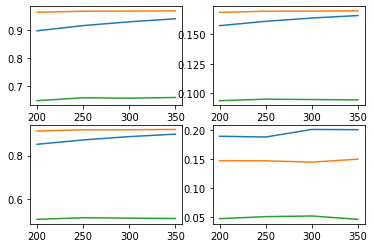

In [27]:
results = pd.DataFrame(model_hist)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
# fig.suptitle('Aligning x-axis using sharex')
ax1.plot(latent_dims, results[results.learning_rate == 0.001].precision.values, label='LR=0.001')
ax1.plot(latent_dims, results[results.learning_rate == 0.01].precision.values, label='LR=0.01')
ax1.plot(latent_dims, results[results.learning_rate == 0.1].precision.values, label='LR=0.1')

ax2.plot(latent_dims, results[results.learning_rate == 0.001].recall.values, label='LR=0.001')
ax2.plot(latent_dims, results[results.learning_rate == 0.01].recall.values, label='LR=0.01')
ax2.plot(latent_dims, results[results.learning_rate == 0.1].recall.values, label='LR=0.1')

ax3.plot(latent_dims, results[results.learning_rate == 0.001].hit_ratio.values, label='LR=0.001')
ax3.plot(latent_dims, results[results.learning_rate == 0.01].hit_ratio.values, label='LR=0.01')
ax3.plot(latent_dims, results[results.learning_rate == 0.1].hit_ratio.values, label='LR=0.1')

ax4.plot(latent_dims, results[results.learning_rate == 0.001].hold_out_hits.values, label='LR=0.001')
ax4.plot(latent_dims, results[results.learning_rate == 0.01].hold_out_hits.values, label='LR=0.01')
ax4.plot(latent_dims, results[results.learning_rate == 0.1].hold_out_hits.values, label='LR=0.1')

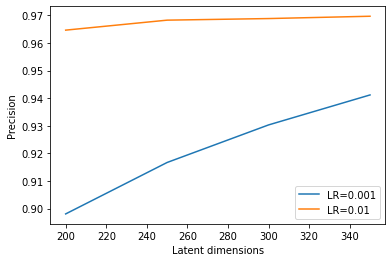

In [34]:
plt.plot(latent_dims, results[results.learning_rate == 0.001].precision.values, label='LR=0.001')
plt.plot(latent_dims, results[results.learning_rate == 0.01].precision.values, label='LR=0.01')
# plt.plot(latent_dims, results[results.learning_rate == 0.1].precision.values, label='LR=0.1')
plt.xlabel('Latent dimensions')
plt.ylabel('Precision')
plt.legend()
plt.show();

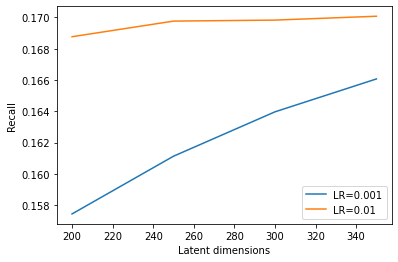

In [35]:
plt.plot(latent_dims, results[results.learning_rate == 0.001].recall.values, label='LR=0.001')
plt.plot(latent_dims, results[results.learning_rate == 0.01].recall.values, label='LR=0.01')
# plt.plot(latent_dims, results[results.learning_rate == 0.1].recall.values, label='LR=0.1')
plt.xlabel('Latent dimensions')
plt.ylabel('Recall')
plt.legend()
plt.show();

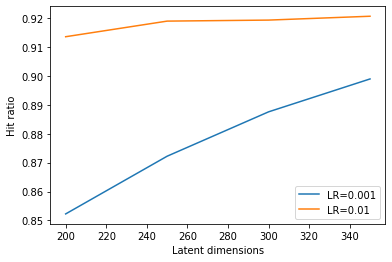

In [36]:
plt.plot(latent_dims, results[results.learning_rate == 0.001].hit_ratio.values, label='LR=0.001')
plt.plot(latent_dims, results[results.learning_rate == 0.01].hit_ratio.values, label='LR=0.01')
# plt.plot(latent_dims, results[results.learning_rate == 0.1].hit_ratio.values, label='LR=0.1')
plt.xlabel('Latent dimensions')
plt.ylabel('Hit ratio')
plt.legend()
plt.show();

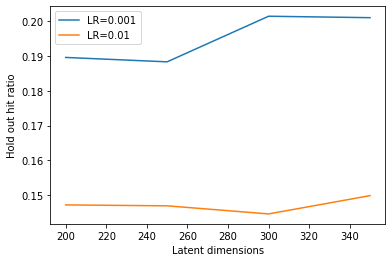

In [37]:
plt.plot(latent_dims, results[results.learning_rate == 0.001].hold_out_hits.values, label='LR=0.001')
plt.plot(latent_dims, results[results.learning_rate == 0.01].hold_out_hits.values, label='LR=0.01')
# plt.plot(latent_dims, results[results.learning_rate == 0.1].hold_out_hits.values, label='LR=0.1')
plt.xlabel('Latent dimensions')
plt.ylabel('Hold out hit ratio')
plt.legend()
plt.show();

In [38]:
results

,latent_dim,learning_rate,precision,recall,hit_ratio,hold_out_hits
0,200,0.001,0.898046,0.157440,0.852244,0.189554
1,200,0.010,0.964685,0.168766,0.913556,0.147237
2,200,0.100,0.646932,0.093420,0.505693,0.046645
3,250,0.001,0.916698,0.161128,0.872210,0.188296
4,250,0.010,0.968306,0.169764,0.918955,0.146971
5,250,0.100,0.657485,0.094732,0.512799,0.050127
6,300,0.001,0.930318,0.163965,0.887564,0.201378
7,300,0.010,0.968883,0.169829,0.919309,0.144650
8,300,0.100,0.655941,0.094416,0.511084,0.051239
9,350,0.001,0.941188,0.166068,0.898947,0.200967


In [17]:
pd.DataFrame(model_hist)

,latent_dim,learning_rate,precision,recall,hit_ratio,hold_out_hits
0,300,0.01,0.968754,0.169832,0.919323,0.145883
1,350,0.01,0.968621,0.169738,0.918816,0.141627
